In [1]:
# based on https://www.coursera.org/lecture/customising-models-tensorflow2/custom-layers-HozmM
# and
# https://www.youtube.com/watch?v=cKMJDkWSDnY&feature=emb_logo
# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/TensorFlow/Basics/tutorial9-custom-layers.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [184]:

def relu_n(x, n = 1):
  """ReLU activation clipped at n."""
  return tf.clip_by_value(x, 0, n)


In [3]:
class LinearMap(Layer):
    def __init__(self, input_dim, units):
        super(LinearMap, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                initializer='random_normal')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)

In [4]:
linear_layer = LinearMap(3, 2)

In [5]:
linear_layer(tf.ones((1, 3)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02130845, 0.09714751]], dtype=float32)>

In [6]:
# class AffineMap(Layer):
#     def __init__(self, input_dim, units):
#         super(AffineMap, self).__init__()
#         self.w = self.add_weight(shape=(input_dim, units),
#                                 initializer='random_normal')
#         self.b = self.add_weight(shape=(units,),
#                                 initializer='random_normal')
        
#     def call(self, inputs):
#         return tf.matmul(inputs, self.w) + self.b

In [7]:
# afine_layer = AffineMap(3, 2)

In [8]:
class AffineMap(Layer):
    def __init__(self, units):
        super(AffineMap, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer='random_normal',
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(self.units,),
            initializer='random_normal',
            trainable=True
        )
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [9]:
afine_layer = AffineMap(2)

In [10]:
afine_layer(tf.ones((1, 3)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02201245, 0.13944918]], dtype=float32)>

In [11]:
afine_layer.built

True

In [185]:
class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._beta_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._beta_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            initializer=tf.initializers.TruncatedNormal(stddev=0.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [186]:
exu_layer = ExU(2)
exu_layer(tf.ones((1, 2)))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [64]:
tf.ones((1, 3)).shape

TensorShape([1, 3])

In [35]:
my_input = tf.ones((3, 2))
my_b = tf.ones((1, 2))
my_b_tiled = tf.tile(my_b, [tf.shape(my_input)[0], 1])


# my_w = tf.ones((2, 3))

In [36]:
my_input

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)>

In [37]:
my_b_tiled

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)>

In [38]:
my_input - my_b_tiled

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

In [123]:
tf.matmul((my_input - my_b), tf.math.exp(my_w))

InvalidArgumentError: Incompatible shapes: [1,2] vs. [1,3] [Op:Sub]

In [104]:
# tf.math.exp(my_w) * (my_input - my_b)
tf.matmul((my_input - my_b), tf.math.exp(my_w))

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,2], In[1]: [1,2] [Op:MatMul]

In [87]:
tf.matmul(my_input, my_w)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[3., 3.]], dtype=float32)>

In [465]:
# def gen_test_data():
#     x = np.linspace(0, 1, 200)[:, np.newaxis]
#     y = x**2
#     return x, y

def gen_test_data():
    x = np.linspace(-1, 1, 200)[:, np.newaxis]
    y = np.random.uniform(-1,1,size=x.shape)
    return x, y

In [466]:
x, y = gen_test_data()

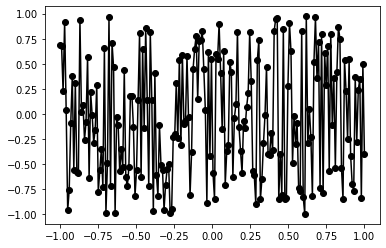

In [467]:
plt.plot(x, y, 'k-o')

In [520]:
input_dim = 1
output_dim = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(input_dim,)))
# model.add(AffineMap(100))
model.add(ExU(1000))
# model.add(tf.keras.layers.Activation('relu'))
model.add(AffineMap(100))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(output_dim, activation='linear'))
model.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ex_u_75 (ExU)                (None, 1000)              2000      
_________________________________________________________________
affine_map_33 (AffineMap)    (None, 100)               100100    
_________________________________________________________________
activation_84 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 102,201
Trainable params: 102,201
Non-trainable params: 0
_________________________________________________________________


In [521]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
model.compile(loss='mse', optimizer=opt)

In [529]:
%%time
history = model.fit(x, y, epochs=1000, batch_size=x.shape[0])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 2/1000
1/1 [==============================] - 0s 877us/step - loss: 0.0440
Epoch 3/1000
1/1 [==============================] - 0s 847us/step - loss: 0.0440
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0440
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0439
Epoch 6/1000
1/1 [==============================] - 0s 913us/step - loss: 0.0439
Epoch 7/1000
1/1 [==============================] - 0s 833us/step - loss: 0.0438
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.0437
Epoch 9/1000
1/1 [==============================] - 0s 853us/step - loss: 0.0437
Epoch 10/1000
1/1 [==============================] - 0s 751us/step - loss: 0.0436
Epoch 11/1000
1/1 [==============================] - 0s 954us/step - loss: 0.0436
Epoch 12/1000
1/1 [==============================] - 0s 743us/step - loss: 0.0435
Epoch 13/1000
1/1 [==============

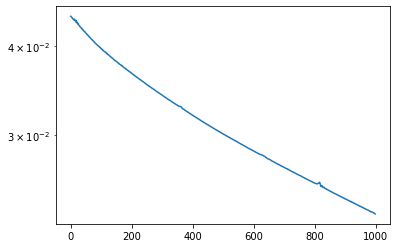

In [530]:
plt.figure()
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

In [531]:
x.shape

(200, 1)

In [532]:
yhat = model.predict(x)

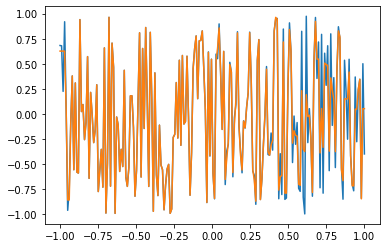

In [533]:
plt.plot(x, y)
plt.plot(x, yhat)
# plt.xlim(-0.25, 0)

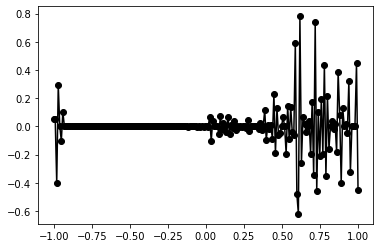

In [534]:
plt.plot(x, y-yhat, 'k-o')

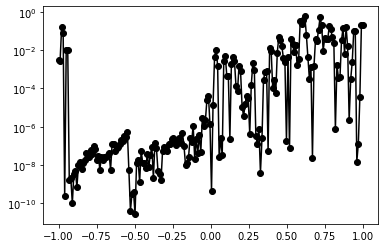

In [535]:
plt.plot(x, tf.keras.losses.mean_squared_error(y,yhat), 'k-o')
plt.yscale('log')